# Burgers Equation PINN

In [ ]:
import torch
import sys
from scipy.stats import qmc # For hypercube sampling
import matplotlib.pyplot as plt

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../utils')
from BVP import BVP
from UPINN import UPINN
from Architectures import FNN
# from Plotters import Burger_Plotter

Consider Burgers equation:

\begin{align}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{align}

where $u(x,t)$ is the velocity field, $\nu$ is the viscosity coefficient, $x \in [-1,1]$ and $t \in [0,1]$. The initial condition is $u(x,0) = -\sin(\pi x)$ and the boundary conditions are $u(-1,t) = u(1,t) = 0$.

### Setup Boundary Value Problem

In [ ]:
# Initial condition
N_ic = 100
u0 = lambda x: -torch.sin(torch.pi * x)
x0 = torch.linspace(-1, 1, N_ic)
t0 = torch.zeros_like(x0)
X0 = torch.stack((t0, x0), dim=-1)
U0 = u0(x0).reshape(-1, 1)

In [ ]:
# Boundary condition
N_bc = 100
uL = lambda t: torch.zeros_like(t)
uR = lambda t: torch.zeros_like(t)
tL = torch.linspace(0, 1, N_bc)
tR = torch.linspace(0, 1, N_bc)
xL = -torch.ones_like(tL)
xR = torch.ones_like(tR)
XL = torch.stack((tL, xL), dim=-1)
XR = torch.stack((tR, xR), dim=-1)
Xbc = torch.cat((XL, XR), dim=0)
Ubc = torch.cat((uL(tL).reshape(-1, 1), uR(tR).reshape(-1, 1)), dim=0)

In [ ]:
# Collocation points
N_coll = 10000
hypercube = qmc.LatinHypercube(d=2)
Xc = torch.tensor(hypercube.random(n=N_coll), dtype=torch.float32)
Xc[:, 1] = Xc[:, 1]*2 - 1

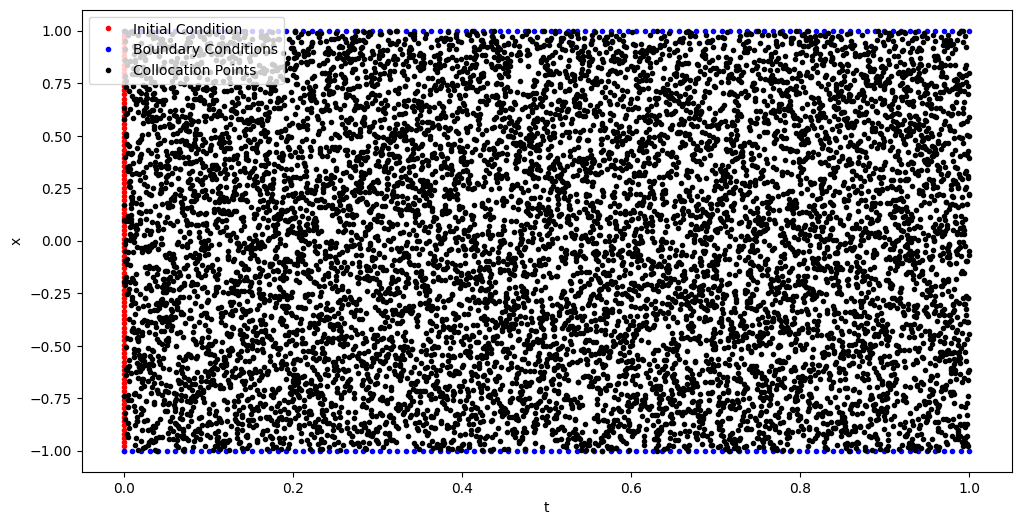

In [ ]:
# Plot the initial condition, boundary conditions, and collocation points
plt.figure(figsize=(12, 6))
plt.plot(X0[:, 0], X0[:, 1], 'r.', label='Initial Condition')
plt.plot(Xbc[:, 0], Xbc[:, 1], 'b.', label='Boundary Conditions')
plt.plot(Xc[:, 0], Xc[:, 1], 'k.', label='Collocation Points')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()

### Setup Boundary Value Problem

In [ ]:
class Burger(torch.nn.Module):
    def __init__(self, nu):
        super(Burger, self).__init__()
        self.nu = nu
    
    def forward(self, X, u):

        dudxt = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
        u_t = dudxt[:,0:1]
        u_x = dudxt[:,1:2]
        
        u_xx = torch.autograd.grad(dudxt, X, torch.ones_like(dudxt), create_graph=True)[0][:,1:2]

        return u_t + u*u_x - self.nu*u_xx

### Initiaize and train PINN

In [ ]:
# Define model architectures
hidden = [20] * 8
u = FNN(
    dims=[2, *hidden, 1],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)
G = FNN(
    dims=[3, *hidden, 1],
    hidden_act=torch.nn.Tanh(),
    output_act=lambda x: torch.zeros_like(x),
)

nu = 0.01/torch.pi
F = Burger(nu)

# Instantiate the UPINN
upinn = UPINN(u, F, G, initial_points=(X0, U0), boundary_points=(Xbc, Ubc), collocation_points=Xc)

In [ ]:
# Train the UPINN
upinn.train_loop(epochs=10000, optimizer=torch.optim.AdamW, optimizer_args=dict(lr=3e-3, weight_decay=1e-10))

Beginning training...
Running on: cpu


100%|██████████| 10000/10000 [16:22<00:00, 10.18it/s, loss=1.42e-02, init_loss=4.17e-04, bc_loss=5.89e-04, data_loss=0.00e+00, pde_loss=1.32e-02]

Training complete.
Moving model to CPU...


### Plot Results

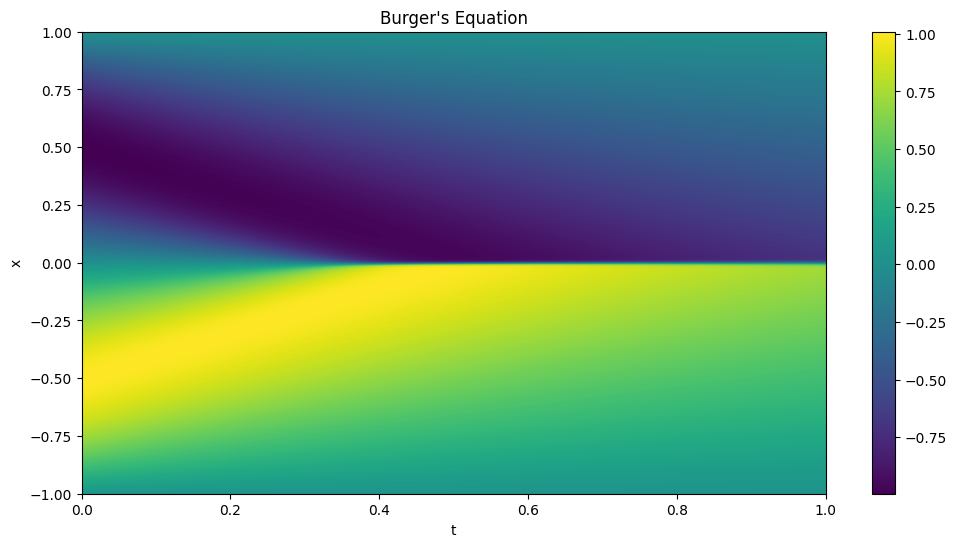

In [ ]:
# Make grid
N = 1000
x = torch.linspace(-1, 1, N)
t = torch.linspace(0, 1, N)
X, T = torch.meshgrid(x, t, indexing='ij')
X_star = torch.stack((T.flatten(), X.flatten()), dim=-1)

# Compute the solution
u_star = upinn.predict(X_star)
u = u_star.reshape(N, N).detach().numpy()

# Plot the solution
plt.figure(figsize=(12, 6))
plt.imshow(u, extent=(0, 1, -1, 1), origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Burger\'s Equation')
plt.show()

Make a class that can plot the results of the UPINN.

In [ ]:
plotter = Burger_Plotter()
plotter(upinn.u, upinn.G)["Heatmap"].show()

NameError: name 'Burger_Plotter' is not defined

In [ ]:
# Function for refining collocation points based on loss

def collocation_refiner(u_hat, pde_func):
    # Use RAD algorithm to refine collocation points
    N = 1000000
    D = 1000

    x = torch.rand(N, 1, requires_grad=True)*2 - 1    # Random points in [-1, 1]
    t = torch.rand(N, 1, requires_grad=True)
    z = torch.cat([t, x], dim=1)

    # Compute the residual
    u = u_hat(z)
    residual = pde_func(u, z)

    # Sample D points with the largest residual
    residual = residual.detach().numpy()
    
    return z[torch.argsort(residual, descending=True)[:D]]

## Train UPINN

In [ ]:
upinn.train(
    data_points=None,
    data_target=None,
    boundary_points=boundary_points,
    collocation_points=z_f.requires_grad_(True),
    epochs=10000,
    # log_wandb=dict(name='PINN-Burgers', project='Master-Thesis', plotter=plotter, plot_interval=5),
    log_wandb=None,
    optimizer=torch.optim.Adam,
    optimizer_args=dict(lr=0.001),
    # optimizer=torch.optim.LBFGS,
    # optimizer_args=dict(lr=0.8),
    # beta_softadapt=0.1,
    # scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    # scheduler_args=dict(factor=0.9, patience=100, min_lr=1e-6),
    loss_tol=1e-5,
    lambda_reg=0.0,
    # priotize_pde=100.0,
    collocation_refiner=collocation_refiner,
    )

Beginning training...
Running on: cuda


  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 57%|█████▋    | 5672/10000 [01:00<00:46, 93.52it/s, Loss=1e-5, BC Loss=1.1e-5, PDE Loss=1.8e-5, Data Loss=0, Reg Loss=0, LR_reg=0]         

Loss below tolerance at epoch 5672. Terminating training.
Training complete.


{'Heatmap': <module 'matplotlib.pyplot' from 'C:\\Users\\jonas\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\matplotlib\\pyplot.py'>}

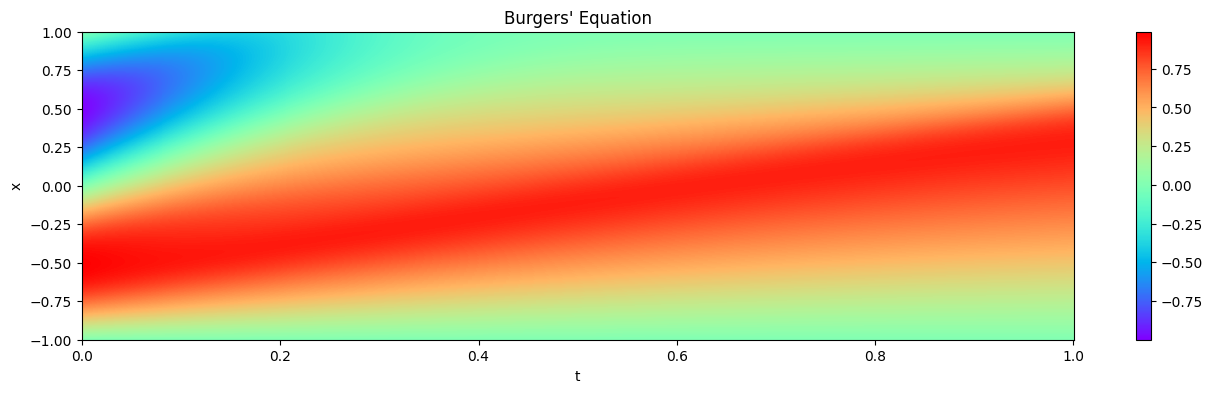

In [ ]:
Burger_Plotter()(upinn.u, upinn.G)

## Improve physics loss

In [ ]:
# Extend collocation points to include the entire time interval and train again
upinn.train(
    data_points=t_d.unsqueeze(-1),
    data_target=X_d,
    boundary_points=torch.tensor([[0.0]]),
    collocation_points=t[train_idx].unsqueeze(-1).requires_grad_(True),
    epochs=10000,
    log_wandb=None,
    optimizer=torch.optim.AdamW,
    optimizer_args=dict(lr=3e-4, weight_decay=1e-10),
    beta_softadapt=0.1,
    loss_tol=1e-6,
    priotize_pde=1000,
    )

NameError: name 't_d' is not defined

In [ ]:
plots = plotter(upinn.u, upinn.G)
plots["Solution"].show()
plots["Missing Terms"].show()

## Train beyond the data

In [ ]:
# Freeze G and parameters
G.requires_grad_(False);
bvp.requires_grad_(False);

# Extend collocation points to include the entire time interval and train again
upinn.train(
    data_points=t_d.unsqueeze(-1),
    data_target=X_d,
    boundary_points=torch.tensor([[0.0]]),
    collocation_points=t.unsqueeze(-1).requires_grad_(True),
    epochs=10000,
    log_wandb=None,
    optimizer=torch.optim.AdamW,
    optimizer_args=dict(lr=3e-4, weight_decay=1e-10),
    beta_softadapt=0.1,
    loss_tol=1e-6,
    priotize_pde=1000,
    )

Beginning training...
Running on: cpu


100%|██████████| 10000/10000 [02:12<00:00, 75.51it/s, Loss=0.0397, BC Loss=0.00265, PDE Loss=0.0858, Data Loss=0.0305, Reg Loss=0.242, LR_reg=0]

Training complete.


In [ ]:
plots = plotter(upinn.u, upinn.G)
plots["Solution"].show()
plots["Missing Terms"].show()